In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct


In [2]:
import datashader.transfer_functions as tf
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import dynspread
from holoviews.operation.datashader import datashade
import hvplot

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)
width, height = plt.rcParams.get('figure.figsize')

In [4]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
import seaborn as sns

In [5]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [6]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

In [7]:
def divv(Vx, Vy, stepsize):
    dvx_dx = np.gradient(Vx, axis=0)/stepsize
    dvy_dy = np.gradient(Vy, axis=1)/stepsize

    DIV = dvx_dx + dvy_dy
    return DIV

def rotorr(Vx, Vy, stepsize):
    dvx_dy = np.gradient(Vx, axis=1)/stepsize
    dvy_dx = np.gradient(Vy, axis=0)/stepsize

    ROTOR = dvy_dx - dvx_dy
    return ROTOR

In [8]:
Vxm1 = fits.open("VelocitiesRS_TAU_0_100.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("VelocitiesRS_TAU_0_100.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm1 = fits.open("VelocitiesRS_TAU_0_100.fits")[2].data
Vxm1 = Vxm1[::3,::2,::2]/1E5
Vym1 = Vym1[::3,::2,::2]/1E5
Vzm1 = Vzm1[::3,::2,::2]/1E5
Vxm1 = Vxm1.transpose(0, 2, 1)
Vym1 = Vym1.transpose(0, 2, 1)
Vzm1 = Vzm1.transpose(0, 2, 1)

In [9]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz1 = Vx_Bz1[:30,::2,::2]
Vy_Bz1 = Vy_Bz1[:30,::2,::2]

In [10]:
Vx_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz2 = Vx_Bz2[:30,::2,::2]
Vy_Bz2 = Vy_Bz2[:30,::2,::2]

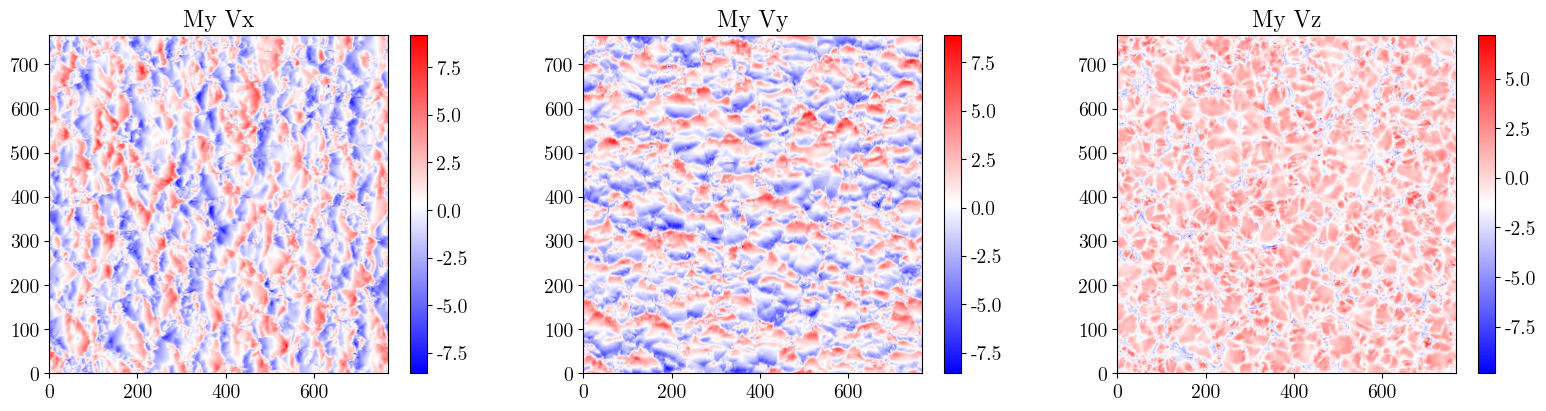

In [11]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(Vxm1[0].T, origin = "lower", cmap = "bwr")
plt.title("My Vx")
plt.colorbar()
plt.subplot(132)
plt.imshow(Vym1[0].T, origin = "lower", cmap = "bwr")
plt.title("My Vy")
plt.colorbar()
plt.subplot(133)
plt.imshow(Vzm1[0].T, origin = "lower", cmap = "bwr")
plt.title("My Vz")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [12]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data.transpose(0, 2, 1)

In [13]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [14]:
Vxm1_filtered600 = gaussian_filter(Vxm1_mean, 22.5/2, mode = "wrap")
Vym1_filtered600 = gaussian_filter(Vym1_mean, 22.5/2, mode = "wrap")

In [15]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25/2, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25/2, mode = "wrap")

In [16]:
Vxm2 = fits.open("VelocitiesRS_TAU_0_010.fits")[1].data # Vy from Velocities.fits as originally thought
Vym2 = fits.open("VelocitiesRS_TAU_0_010.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm2 = fits.open("VelocitiesRS_TAU_0_010.fits")[2].data
Vxm2 = Vxm2[::3,::2,::2]/1E5
Vym2 = Vym2[::3,::2,::2]/1E5
Vzm2 = Vzm2[::3,::2,::2]/1E5
Vxm2 = Vxm2.transpose(0, 2, 1)
Vym2 = Vym2.transpose(0, 2, 1)
Vzm2 = Vzm2.transpose(0, 2, 1)

In [17]:
Vxm2_mean = temporal_avg(Vxm2, 0, 90)
#Vxm2_mean = Vxm2_mean/1E5
Vym2_mean = temporal_avg(Vym2, 0, 90)
#Vym2_mean = Vym2_mean/1E5

In [18]:
Vxm2_filtered600 = gaussian_filter(Vxm2_mean, 22.5/2, mode = "wrap")
Vym2_filtered600 = gaussian_filter(Vym2_mean, 22.5/2, mode = "wrap")

In [19]:
Vxm2_filtered300 = gaussian_filter(Vxm2_mean, 11.25/2, mode = "wrap")
Vym2_filtered300 = gaussian_filter(Vym2_mean, 11.25/2, mode = "wrap")

In [20]:
Vx_BzFeI_mean = temporal_avg(Vx_ME_FeI, 0, 90)
Vy_BzFeI_mean = temporal_avg(Vy_ME_FeI, 0, 90)

In [21]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")

In [22]:
Vx_Bz2_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")

In [23]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [24]:
Vx_Bz1_mean = temporal_avg(Vx_Bz1, 0, 90)
Vy_Bz1_mean = temporal_avg(Vy_Bz1, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [25]:
Vx_Bz2_mean = temporal_avg(Vx_Bz2, 0, 90)
Vy_Bz2_mean = temporal_avg(Vy_Bz2, 0, 90)
#Vx_Bz2_mean = Vx_Bz2_mean[::2,::2]
#Vy_Bz2_mean = Vy_Bz2_mean[::2,::2]

In [26]:
Vx_Bz2_cor = Vx_Bz2_cor[::2,::2]
Vy_Bz2_cor = Vy_Bz2_cor[::2,::2]

In [27]:
Vx_Bz1_cor = Vx_Bz1_cor[::2,::2]
Vy_Bz1_cor = Vy_Bz1_cor[::2,::2]

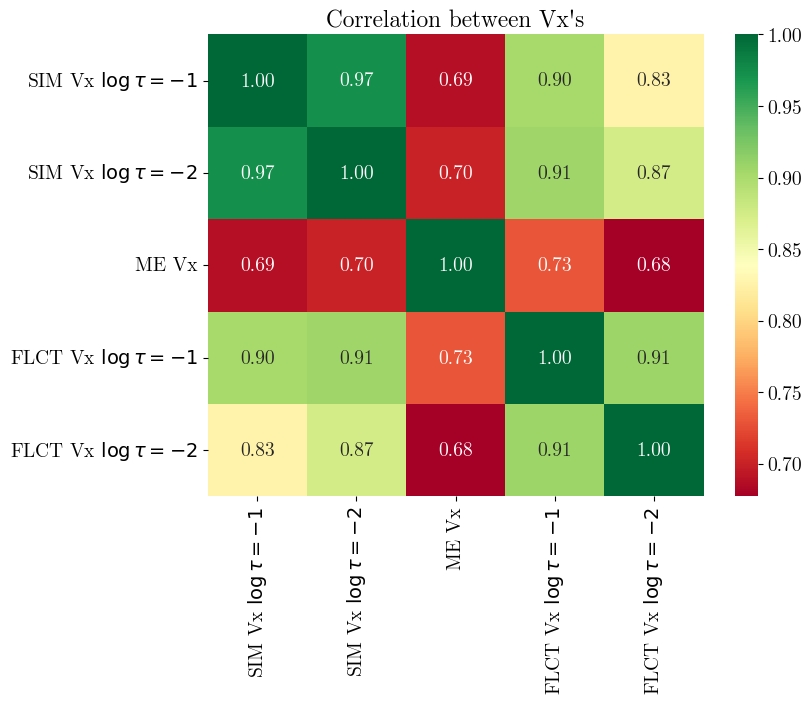

In [28]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s")
#plt.savefig("Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

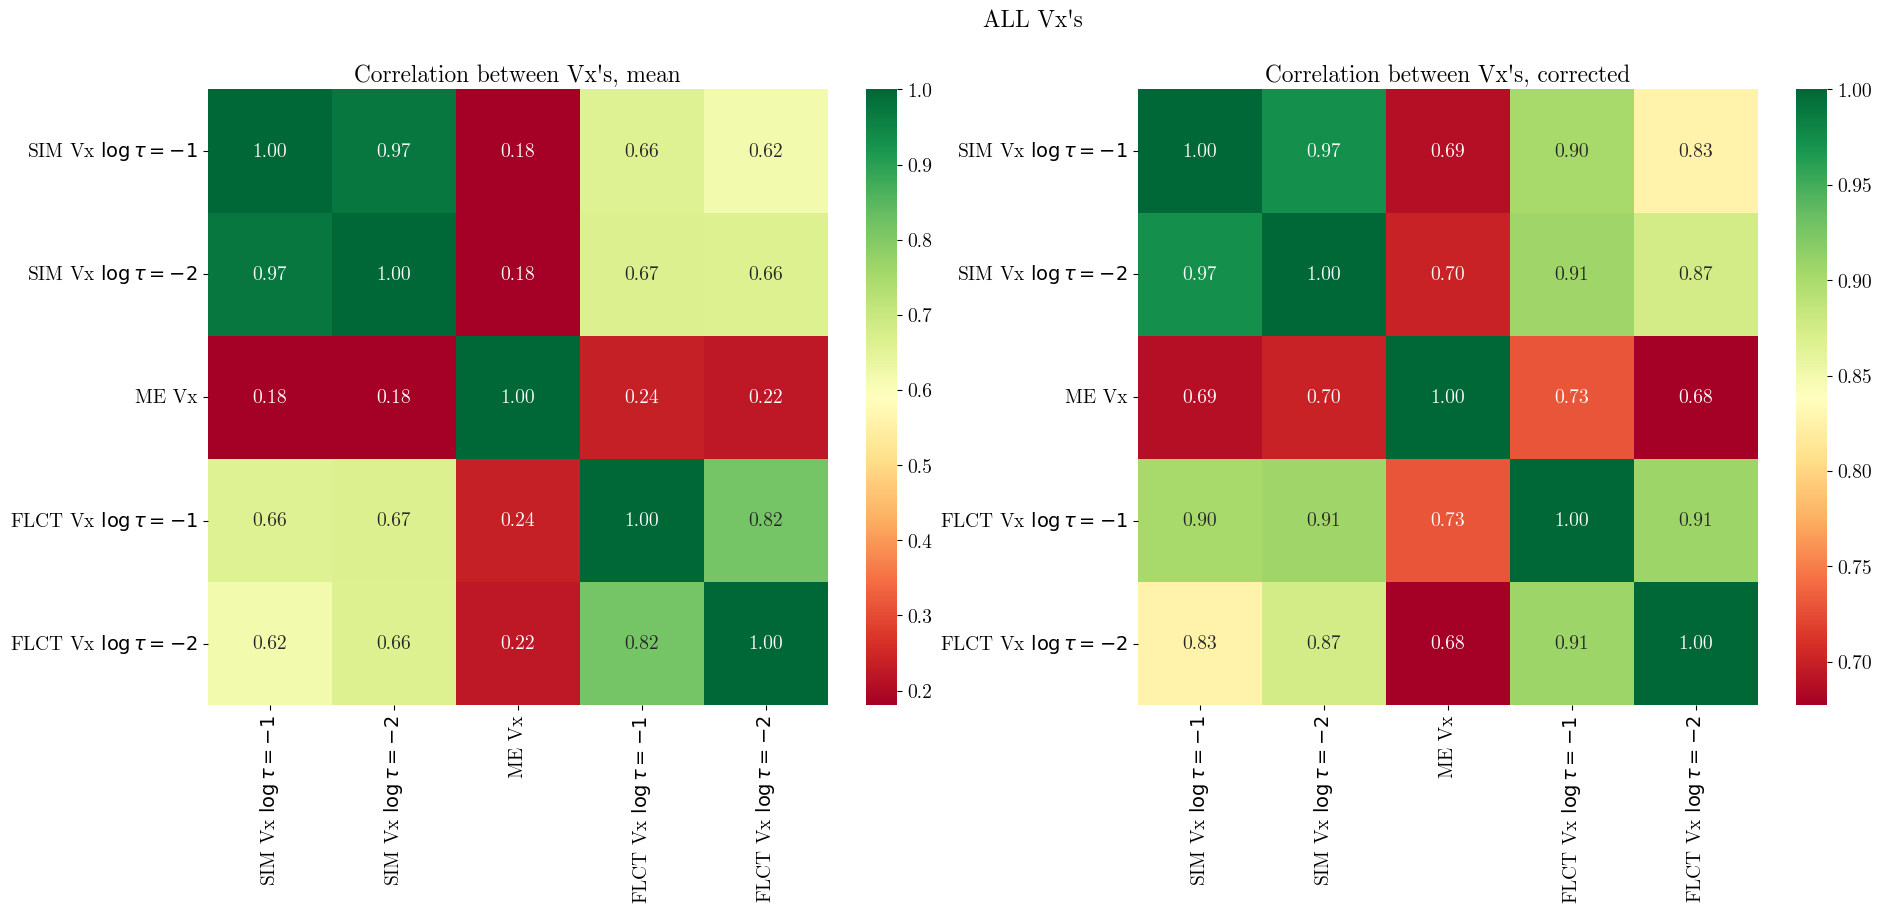

In [29]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

In [30]:
Vxm3 = fits.open("VelocitiesRS_TAU_0_001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym3 = fits.open("VelocitiesRS_TAU_0_001.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm3 = fits.open("VelocitiesRS_TAU_0_001.fits")[2].data
Vxm3 = Vxm3[::3,::2,::2]/1E5
Vym3 = Vym3[::3,::2,::2]/1E5
Vzm3 = Vzm3[::3,::2,::2]/1E5
Vxm3 = Vxm3.transpose(0, 2, 1)
Vym3 = Vym3.transpose(0, 2, 1)
Vzm3 = Vzm3.transpose(0, 2, 1)

In [31]:
Vxm3_mean = temporal_avg(Vxm3, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym3_mean = temporal_avg(Vym3, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [32]:
Vxm3_filtered600 = gaussian_filter(Vxm3_mean, 22.5/2, mode = "wrap")
Vym3_filtered600 = gaussian_filter(Vym3_mean, 22.5/2, mode = "wrap")

In [33]:
Vxm3_filtered300 = gaussian_filter(Vxm3_mean, 11.25/2, mode = "wrap")
Vym3_filtered300 = gaussian_filter(Vym3_mean, 11.25/2, mode = "wrap")

In [34]:
Vxm4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[2].data
Vxm4 = Vxm4[::3,::2,::2]/1E5
Vym4 = Vym4[::3,::2,::2]/1E5
Vzm4 = Vzm4[::3,::2,::2]/1E5
Vxm4 = Vxm4.transpose(0, 2, 1)
Vym4 = Vym4.transpose(0, 2, 1)
Vzm4 = Vzm4.transpose(0, 2, 1)

In [35]:
Vxm4_mean = temporal_avg(Vxm4, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym4_mean = temporal_avg(Vym4, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [36]:
Vxm4_filtered600 = gaussian_filter(Vxm4_mean, 22.5/2, mode = "wrap")
Vym4_filtered600 = gaussian_filter(Vym4_mean, 22.5/2, mode = "wrap")

In [37]:
Vxm4_filtered300 = gaussian_filter(Vxm4_mean, 11.25/2, mode = "wrap")
Vym4_filtered300 = gaussian_filter(Vym4_mean, 11.25/2, mode = "wrap")

In [38]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data.transpose(0, 2, 1)

In [39]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [40]:
Vx_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[1].data.transpose(0, 2, 1)

In [41]:
Vx_BzFeI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")

In [42]:
Vx_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[1].data.transpose(0, 2, 1)

In [43]:
Vx_BzMgI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")

In [44]:
Vx_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[1].data.transpose(0, 2, 1)

In [45]:
Vx_BzMgI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")

In [46]:
logt = [-1.0, -2.0, -3.0, -4.0]
fwhm6x_corM = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0]]

fwhm6y_corM = [pearsonr(Vym1_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0]]

fwhm3x_corM = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0]]

fwhm3y_corM = [pearsonr(Vym1_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0]]

fwhm6x_corF = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0]]
fwhm6y_corF = [pearsonr(Vym1_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0]]

fwhm3x_corF = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0]]

fwhm3y_corF = [pearsonr(Vym1_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0]]

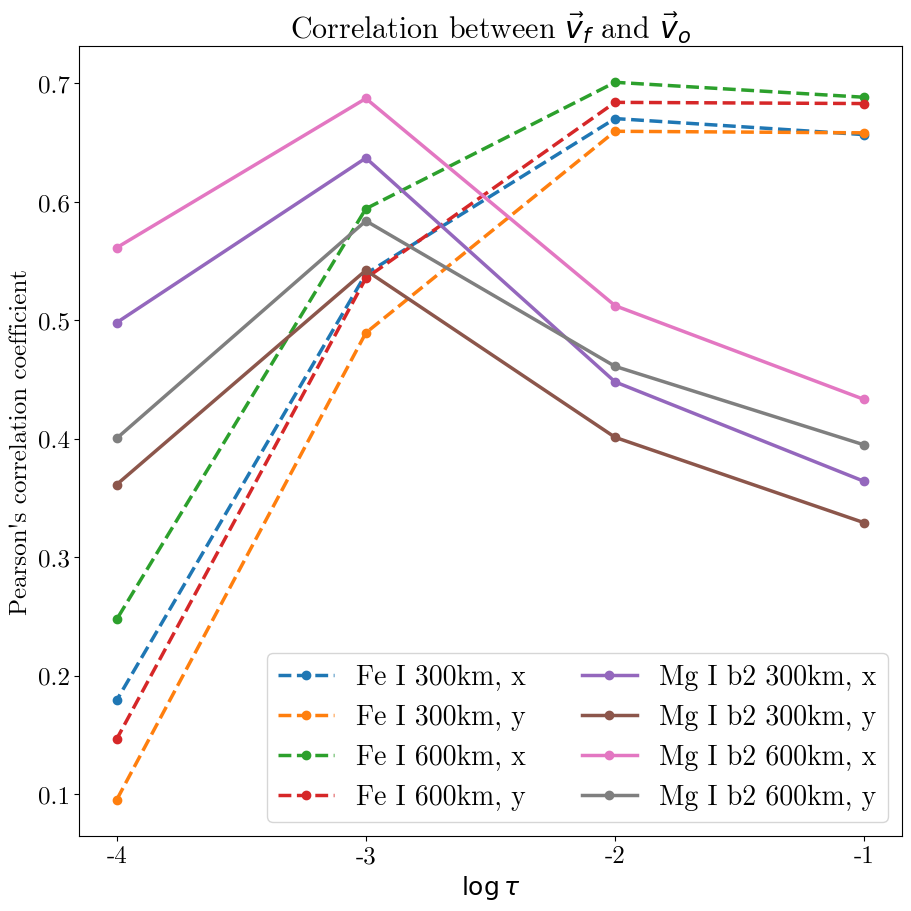

In [47]:
mpl.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize = (9, 9), layout='constrained')
ax.plot(logt, fwhm3x_corF, label="Fe I 300km, x", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3y_corF, label = "Fe I 300km, y", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6x_corF, label = "Fe I 600km, x", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6y_corF, label = "Fe I 600km, y", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3x_corM, label="Mg I b2 300km, x", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3y_corM, label = "Mg I b2 300km, y", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6x_corM, label = "Mg I b2 600km, x", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6y_corM, label = "Mg I b2 600km, y", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.set_ylabel("Pearson's correlation coefficient")
ax.set_title('Correlation between $\\vec{v}_f$ and $\\vec{v}_o$')
ax.set_xlabel("$\log\\tau$")
ax.set_xticks([-1,-2,-3,-4])
#ax.axvline(-4, linewidth = 2, color = "red")
#ax.axvline(-1, linewidth = 2, color = "blue")
ax.legend(loc='best', ncols=2, fontsize = 20)
#plt.savefig("Tables.png", dpi = 200, bbox_inches = 'tight')

<h1>Curl & Divergence</h1>

In [48]:
rotm1 = rotorr(Vxm1_filtered600, Vym1_filtered600, 32)
divm1 = divv(Vxm1_filtered600, Vym1_filtered600, 32)

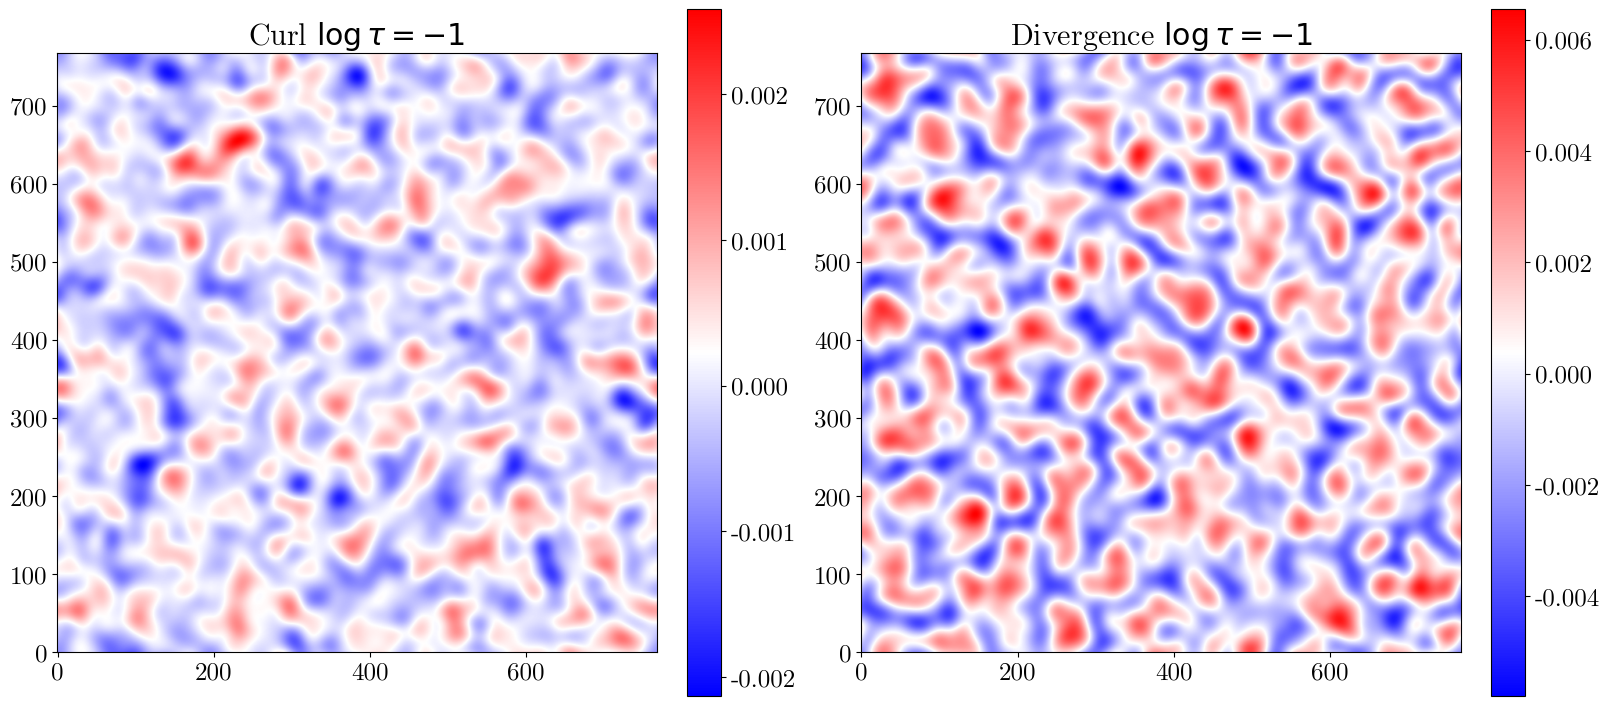

In [49]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotm1.T, origin = "lower", cmap = "bwr")
plt.title("Curl $\log\\tau = -1$")
plt.colorbar()
plt.subplot(122)
plt.imshow(divm1.T, origin = "lower", cmap = "bwr")
plt.title("Divergence $\log\\tau = -1$")
plt.colorbar()

In [50]:
rotmFe = rotorr(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)
divmFe = divv(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)

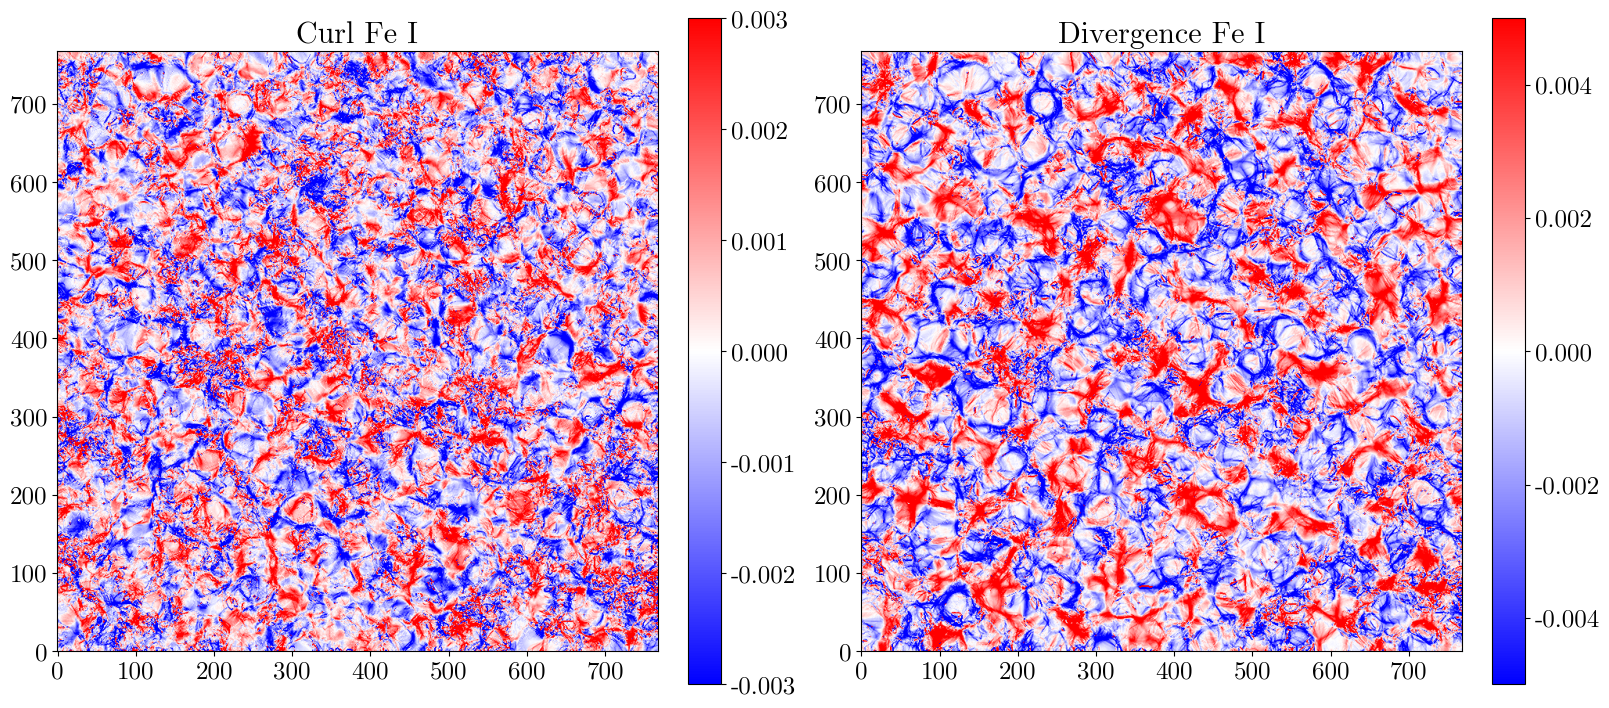

In [51]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotmFe.T, origin = "lower", cmap = "bwr", vmin = -0.003, vmax = 0.003)
plt.title("Curl Fe I")
plt.colorbar()
plt.subplot(122)
plt.imshow(divmFe.T, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Divergence Fe I")
plt.colorbar()

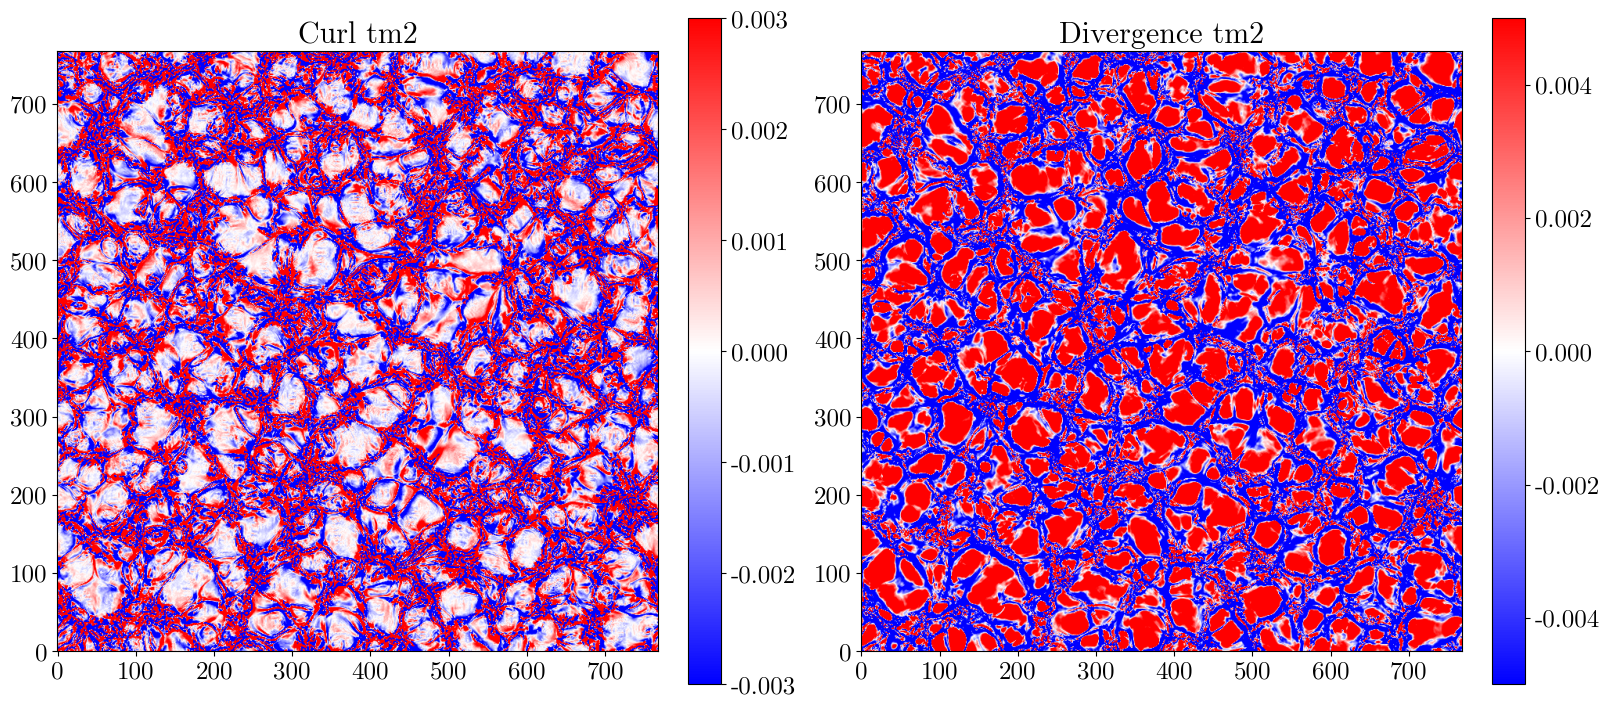

In [52]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotorr(Vxm2[0], Vym2[0], 32).T, origin = "lower", cmap = "bwr", vmin = -0.003, vmax = 0.003)
plt.title("Curl tm2")
plt.colorbar()
plt.subplot(122)
plt.imshow(divv(Vxm2[0], Vym2[0], 32).T, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Divergence tm2")
plt.colorbar()

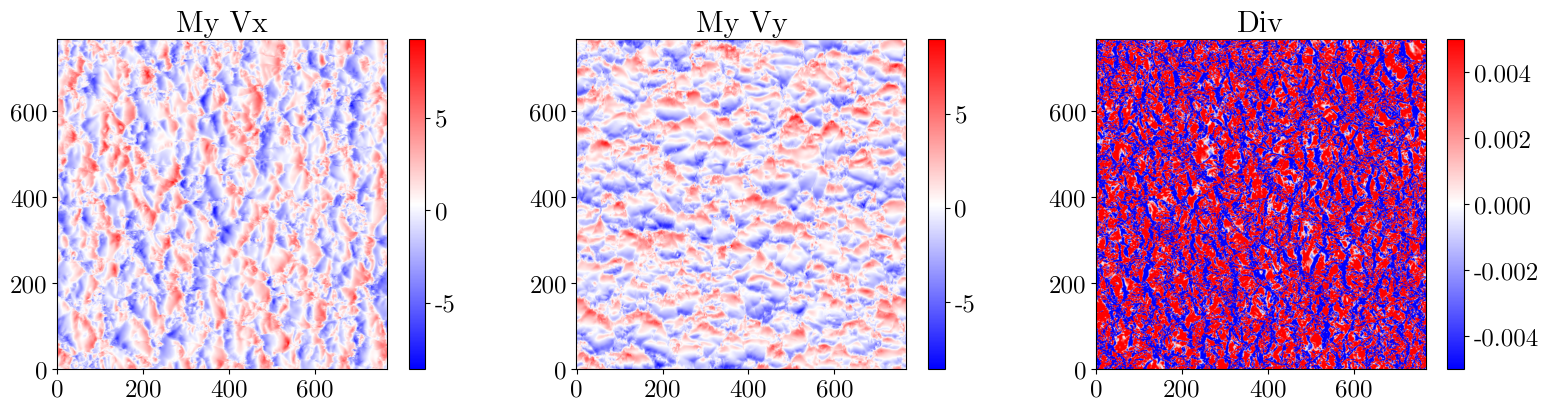

In [53]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(Vxm1[0].T, origin = "lower", cmap = "bwr")
plt.title("My Vx")
plt.colorbar()
plt.subplot(132)
plt.imshow(Vym1[0].T, origin = "lower", cmap = "bwr")
plt.title("My Vy")
plt.colorbar()
plt.subplot(133)
plt.imshow(divv(Vxm1[0].T, Vym1[0], 32), origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Div")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [54]:
divtm1 = divv(Vxm1_filtered600, Vym1_filtered600, 32)
rottm1 = rotorr(Vxm1_filtered600, Vym1_filtered600, 32)
PD = pearsonr(divtm1.flatten(), divmFe.flatten())
print(PD)
PR = pearsonr(rottm1.flatten(), rotmFe.flatten())
print(PR)

PearsonRResult(statistic=np.float64(0.2945384478484335), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.11421371832967796), pvalue=np.float64(0.0))


<h1>!!!Change our functions!!!</h1>

In [55]:
def novi_div(Vx, Vy, stepsize):
    dvx_dx = np.gradient(Vx, axis=1)/stepsize
    dvy_dy = np.gradient(Vy, axis=0)/stepsize

    DIV = dvx_dx + dvy_dy
    return DIV

def novi_rot(Vx, Vy, stepsize):
    dvx_dy = np.gradient(Vx, axis=0)/stepsize
    dvy_dx = np.gradient(Vy, axis=1)/stepsize

    ROTOR = dvy_dx - dvx_dy
    return ROTOR

In [56]:
rotm1N = novi_rot(Vxm1_filtered600, Vym1_filtered600, 32)
divtm1N = novi_div(Vxm1_filtered600, Vym1_filtered600, 32)

rotFeN = novi_rot(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)
divFeN = novi_div(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)

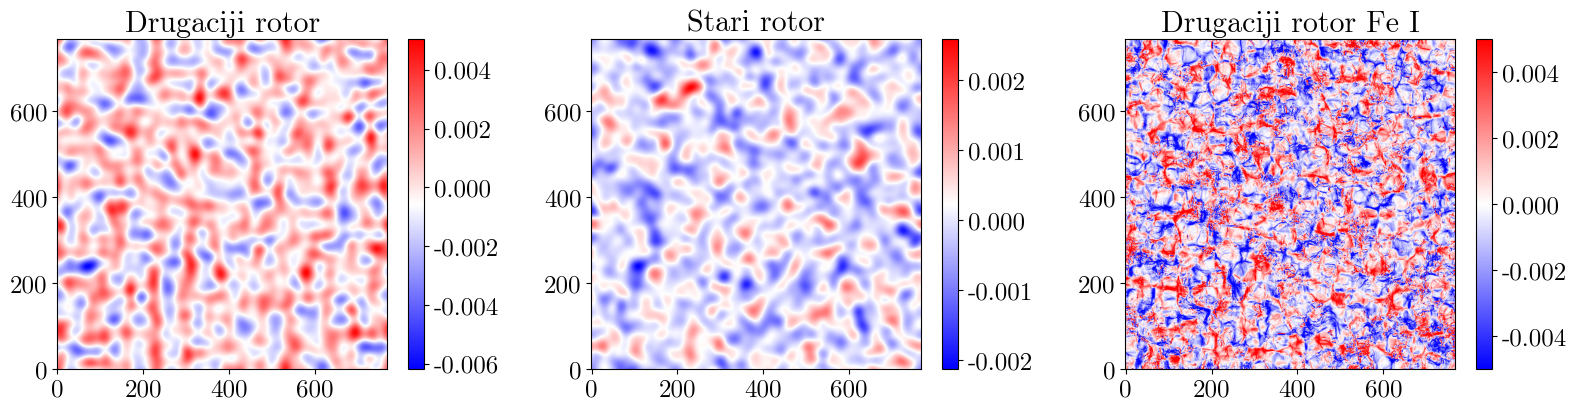

In [57]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(rotm1N.T, origin = "lower", cmap = "bwr")
plt.title("Drugaciji rotor")
plt.colorbar()
plt.subplot(132)
plt.imshow(rottm1.T, origin = "lower", cmap = "bwr")
plt.title("Stari rotor")
plt.colorbar()
plt.subplot(133)
plt.imshow(rotFeN.T, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Drugaciji rotor Fe I")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

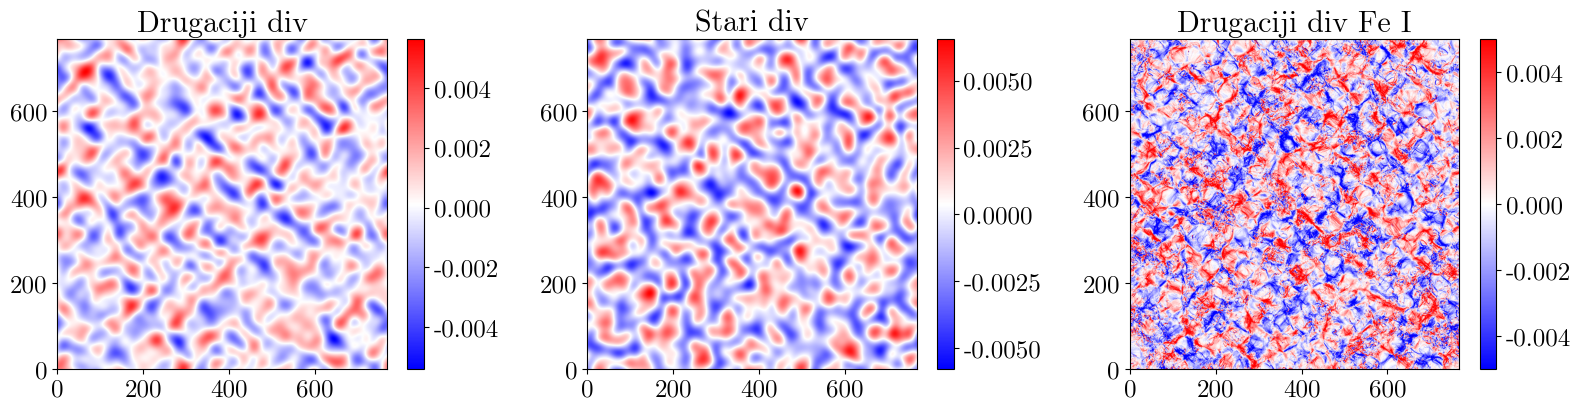

In [58]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(divtm1N.T, origin = "lower", cmap = "bwr")
plt.title("Drugaciji div")
plt.colorbar()
plt.subplot(132)
plt.imshow(divtm1.T, origin = "lower", cmap = "bwr")
plt.title("Stari div")
plt.colorbar()
plt.subplot(133)
plt.imshow(divFeN.T, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Drugaciji div Fe I")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [59]:
print("Novo poredjenje:")
print("Divergencija")
print(pearsonr(divtm1N.flatten(), divFeN.flatten()))
print("Rotor")
print(pearsonr(rotm1N.flatten(), rotFeN.flatten()))
print("-----------------------")
print("Staro poredjenje:")
print("Divergencija")
print(PD)
print("Rotor")
print(PR)

Novo poredjenje:
Divergencija
PearsonRResult(statistic=np.float64(0.24431445818706812), pvalue=np.float64(0.0))
Rotor
PearsonRResult(statistic=np.float64(0.2314421527578781), pvalue=np.float64(0.0))
-----------------------
Staro poredjenje:
Divergencija
PearsonRResult(statistic=np.float64(0.2945384478484335), pvalue=np.float64(0.0))
Rotor
PearsonRResult(statistic=np.float64(0.11421371832967796), pvalue=np.float64(0.0))


<h1>-------------------------</h1>

<h2>Different gaussian_filter widths</h2>

<h1>06. 05. 2025.</h1>

In [60]:
from tqdm import tqdm

In [61]:
widths = np.arange(5.0, 30.0, 0.1)
Vxm1F = []
Vym1F = []
for j in tqdm(range(len(widths))):
    Vx = gaussian_filter(Vxm1_mean, j, mode = "wrap")
    Vy = gaussian_filter(Vym1_mean, j, mode = "wrap")
    Vxm1F.append(Vx)
    Vym1F.append(Vy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:36<00:00,  1.34s/it]


In [62]:
Rotorm1F = []
Divm1F = []
for j in tqdm(range(len(Vxm1F))):
    div = divv(Vxm1F[j], Vym1F[j], 32)
    rot = rotorr(Vxm1F[j], Vym1F[j], 32)
    Rotorm1F.append(rot)
    Divm1F.append(div)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 145.20it/s]


In [63]:
for j in range(len(Divm1F)):
    dummy_D = pearsonr(Divm1F[j].flatten(), divmFe.flatten())
    print("sigma: {}, Pearson's coefficient: {}".format(widths[j], dummy_D[0]))

sigma: 5.0, Pearson's coefficient: 0.189030673583326
sigma: 5.1, Pearson's coefficient: 0.1954385217915283
sigma: 5.199999999999999, Pearson's coefficient: 0.20684673232235964
sigma: 5.299999999999999, Pearson's coefficient: 0.2202705339218673
sigma: 5.399999999999999, Pearson's coefficient: 0.23421466948524286
sigma: 5.499999999999998, Pearson's coefficient: 0.24763893045183683
sigma: 5.599999999999998, Pearson's coefficient: 0.2598382468696621
sigma: 5.6999999999999975, Pearson's coefficient: 0.2703846368300193
sigma: 5.799999999999997, Pearson's coefficient: 0.27907397080226687
sigma: 5.899999999999997, Pearson's coefficient: 0.2858614412304819
sigma: 5.9999999999999964, Pearson's coefficient: 0.29080033494459373
sigma: 6.099999999999996, Pearson's coefficient: 0.29399656847943345
sigma: 6.199999999999996, Pearson's coefficient: 0.295582153264643
sigma: 6.299999999999995, Pearson's coefficient: 0.2957028220891545
sigma: 6.399999999999995, Pearson's coefficient: 0.29451269889196796
s

In [64]:
for j in range(len(Rotorm1F)):
    dummy_R = pearsonr(Rotorm1F[j].flatten(), rotmFe.flatten())
    print("sigma: {}, Pearson's coefficient: {}".format(widths[j], dummy_R[0]))

sigma: 5.0, Pearson's coefficient: 0.0460268324131043
sigma: 5.1, Pearson's coefficient: 0.05834722221033452
sigma: 5.199999999999999, Pearson's coefficient: 0.0739555164423929
sigma: 5.299999999999999, Pearson's coefficient: 0.08705217618521943
sigma: 5.399999999999999, Pearson's coefficient: 0.09748146410872226
sigma: 5.499999999999998, Pearson's coefficient: 0.10538228184743914
sigma: 5.599999999999998, Pearson's coefficient: 0.11094632228230905
sigma: 5.6999999999999975, Pearson's coefficient: 0.11445526166512553
sigma: 5.799999999999997, Pearson's coefficient: 0.11624910793535051
sigma: 5.899999999999997, Pearson's coefficient: 0.11667661908611009
sigma: 5.9999999999999964, Pearson's coefficient: 0.11605615876774913
sigma: 6.099999999999996, Pearson's coefficient: 0.1146580878876936
sigma: 6.199999999999996, Pearson's coefficient: 0.11270034070262186
sigma: 6.299999999999995, Pearson's coefficient: 0.1103529877361975
sigma: 6.399999999999995, Pearson's coefficient: 0.1077468042295

In [65]:
import scipy

<h2>Savitzky-Golay</h2>

In [66]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [67]:
Vxm1SG = sgolay2d(Vxm1_mean, window_size = 29, order = 5)
Vym1SG = sgolay2d(Vym1_mean, window_size = 29, order = 5)

In [68]:
divm1SG = divv(Vxm1SG, Vym1SG, 32)
rotm1SG = rotorr(Vxm1SG, Vym1SG, 32)

In [69]:
print(pearsonr(divm1SG.flatten(), divmFe.flatten()))
#rotmFe
print(pearsonr(rotm1SG.flatten(), rotmFe.flatten()))

PearsonRResult(statistic=np.float64(0.21353481589460074), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.0889147940709515), pvalue=np.float64(0.0))


<h2>Fourier gaussian filter</h2>

In [70]:
Vxm1FT = scipy.ndimage.fourier_gaussian(Vxm1_mean, sigma = 22.5/2)
Vym1FT = scipy.ndimage.fourier_gaussian(Vym1_mean, sigma = 22.5/2)

In [71]:
divm1FT = divv(Vxm1FT, Vym1FT, 32)
rotm1FT = rotorr(Vxm1FT, Vym1FT, 32)

In [72]:
print(pearsonr(divm1FT.flatten(), divmFe.flatten()))
#rotmFe
print(pearsonr(rotm1FT.flatten(), rotmFe.flatten()))

PearsonRResult(statistic=np.float64(0.0033181649185148303), pvalue=np.float64(0.010823311661729442))
PearsonRResult(statistic=np.float64(0.0018669912456320895), pvalue=np.float64(0.15161579010279058))


<h2>LOWESS</h2>

In [73]:
import statsmodels.api as sm
import scipy.stats as st

In [74]:
#Vxm1LOW = sm.nonparametric.lowess(np.take(Vxm1_mean, indices=[1], axis=0), np.take(Vxm1_mean, indices=[1], axis=0))
#Vym1LOW = sm.nonparametric.lowess(Vym1_mean[None,:], Vym1_mean[:,None])

In [75]:
#divm1LOW = divv(Vxm1LOW, Vym1LOW, 32)
#rotm1LOW = rotorr(Vxm1LOW, Vym1LOW, 32)

In [76]:
#print(pearsonr(divm1LOW.flatten(), divmFe.flatten()))
#rotmFe
#print(pearsonr(rotm1LOW.flatten(), rotmFe.flatten()))

In [77]:
#np.shape(Vxm1LOW)

In [78]:
#np.reshape(Vxm1_mean, (0, 1)).shape

(array([1.14992838e-04, 2.29986420e-04, 2.98981379e-04, 6.43961976e-04,
        1.40291262e-03, 1.86289000e-03, 2.89781952e-03, 4.00176371e-03,
        5.26667199e-03, 6.09462042e-03, 7.98052877e-03, 1.07633296e-02,
        1.32702164e-02, 1.62599873e-02, 2.11126851e-02, 2.79893473e-02,
        3.32790350e-02, 4.08684547e-02, 4.76070350e-02, 5.68526430e-02,
        7.01456312e-02, 8.15990499e-02, 9.45012672e-02, 1.06552536e-01,
        1.19799732e-01, 1.33943874e-01, 1.41694404e-01, 1.56942225e-01,
        1.69706979e-01, 1.74559128e-01, 1.80562338e-01, 1.90980106e-01,
        2.00110537e-01, 2.11219528e-01, 2.19958301e-01, 2.28744493e-01,
        2.30629636e-01, 2.44314574e-01, 2.53973182e-01, 2.59792660e-01,
        2.73360975e-01, 2.83710330e-01, 2.85620135e-01, 2.88448035e-01,
        2.93094694e-01, 2.88747016e-01, 2.99350324e-01, 3.01649213e-01,
        3.06317922e-01, 3.12758533e-01, 3.15310362e-01, 3.21245031e-01,
        3.18852141e-01, 3.21245031e-01, 3.22899889e-01, 3.257977

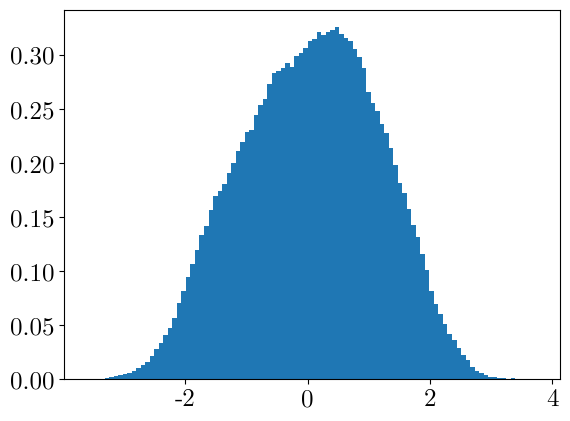

In [79]:
plt.hist(Vxm1_mean.flatten(), density = True, bins = 100)

Freedman–Diaconis number of bins: 187


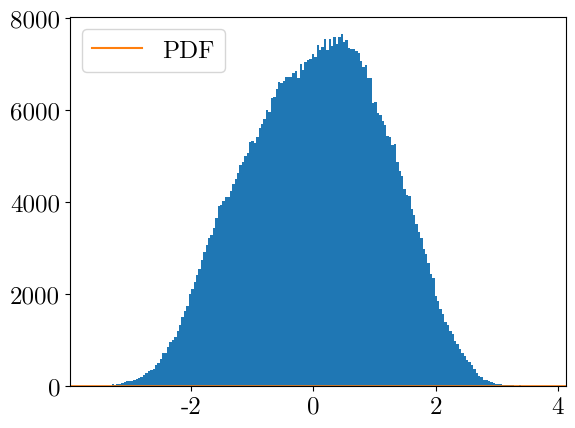

In [80]:
q25, q75 = np.percentile(Vxm1_mean.flatten(), [25, 75])
bin_width = 2 * (q75 - q25) * len(Vxm1_mean.flatten()) ** (-1/3)
bins = round((Vxm1_mean.flatten().max() - Vxm1_mean.flatten().min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(Vxm1_mean.flatten(), bins=bins);
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(Vxm1_mean.flatten())
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")

Freedman–Diaconis number of bins: 178


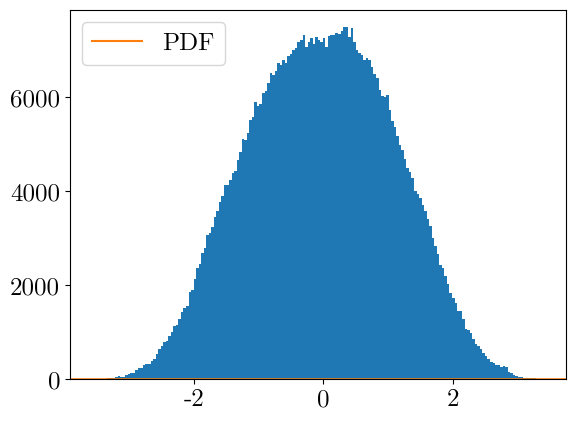

In [81]:
q25, q75 = np.percentile(Vym1_mean.flatten(), [25, 75])
bin_width = 2 * (q75 - q25) * len(Vym1_mean.flatten()) ** (-1/3)
bins = round((Vym1_mean.flatten().max() - Vym1_mean.flatten().min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(Vym1_mean.flatten(), bins=bins);
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(Vym1_mean.flatten())
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")

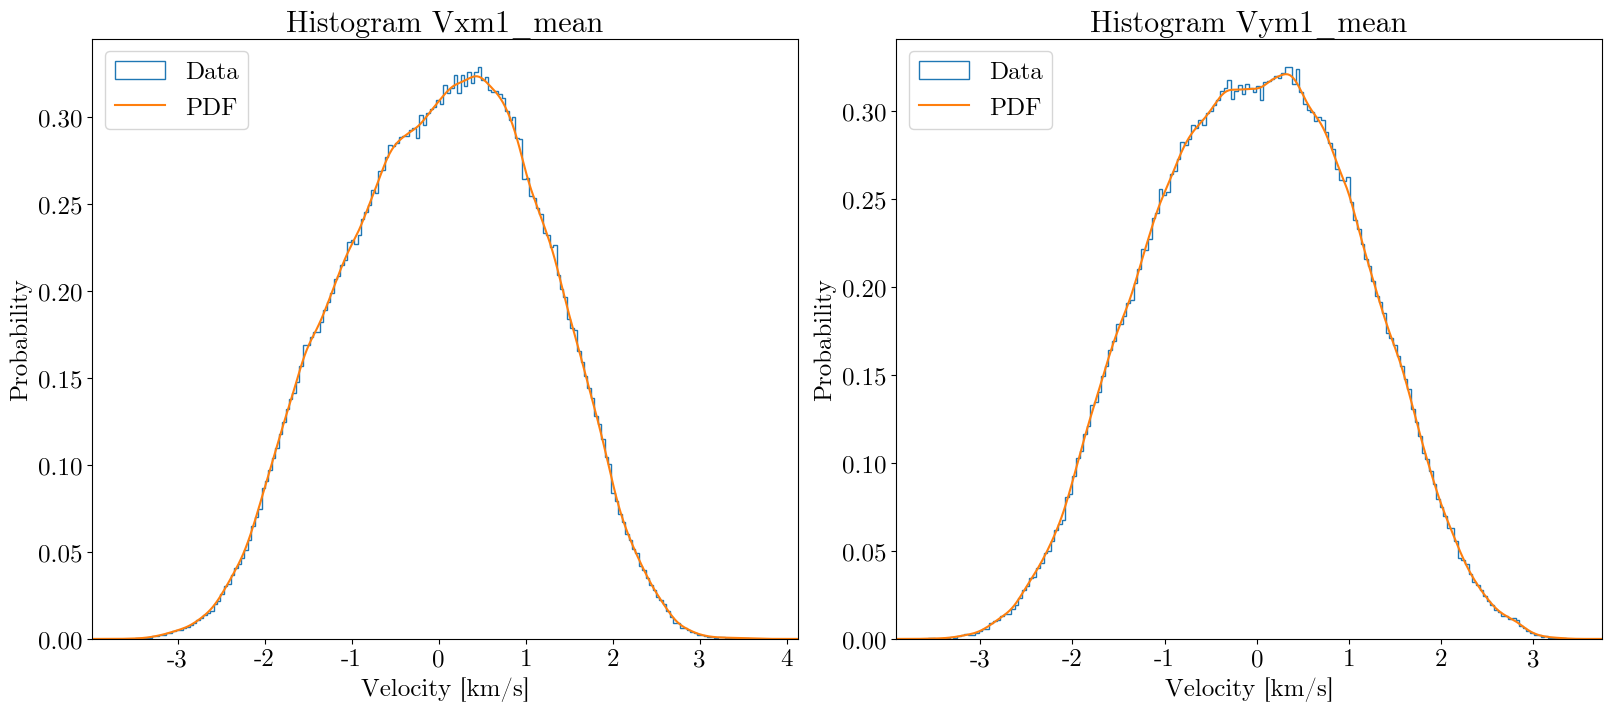

In [82]:

f = plt.figure(constrained_layout = True, figsize = (16, 7))
plt.subplot(121)
plt.hist(Vxm1_mean.flatten(), density = True, bins=187, label = "Data", histtype = "step");
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(Vxm1_mean.flatten())
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Velocity [km/s]")
plt.title("Histogram Vxm1_mean");
plt.subplot(122)
plt.hist(Vym1_mean.flatten(), density = True, bins=178, label = "Data", histtype = "step");
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(Vym1_mean.flatten())
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Velocity [km/s]")
plt.title("Histogram Vym1_mean");

<Figure size 1600x700 with 0 Axes>

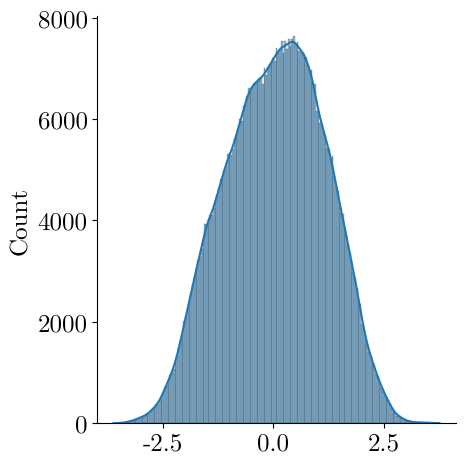

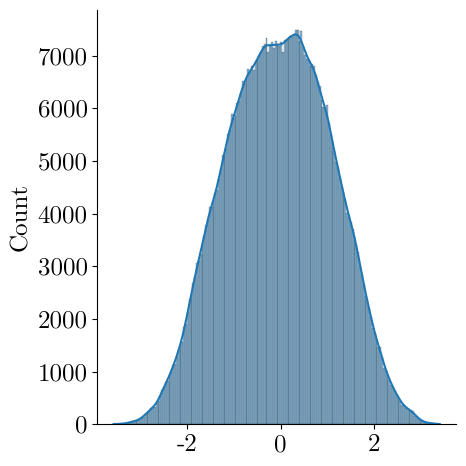

In [84]:
import seaborn as sns
f = plt.figure(constrained_layout = True, figsize = (16, 7))

sns.displot(Vxm1_mean.flatten(), bins = 187, kde=True);

sns.displot(Vym1_mean.flatten(), bins = 178, kde=True);